In [19]:
%pylab inline
import pymc as pm
from IPython.display import Image # to render png from pydot inline

Populating the interactive namespace from numpy and matplotlib


In [20]:
disasters_array =   \
     np.array([ 4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                   3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                   2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                   1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                   0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                   3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                   0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

(-0.5, 6.5)

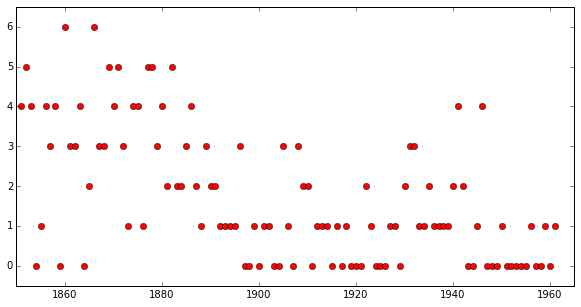

In [21]:
figsize(10,5)
plt.plot(np.arange(1851,1962), disasters_array, 'ro')
plt.xlim(1850,1965); plt.ylim(-0.5,6.5)

In [22]:
switchpoint = pm.DiscreteUniform('switchpoint', lower=0, upper=110,
                                 doc='Switchpoint[year]')

In [23]:
early_mean = pm.Exponential('early_mean', beta=1.)
late_mean = pm.Exponential('late_mean', beta=1.)

In [24]:
@pm.deterministic
def rate(s=switchpoint, e=early_mean, l=late_mean):
    ''' Concatenate Poisson means '''
    out = np.empty(len(disasters_array))
    out[:s] = e
    out[s:] = l
    return out

In [25]:
disasters = pm.Poisson('disasters', mu=rate, value=disasters_array,
                       observed=True)

In [26]:
model = pm.Model([disasters, rate, early_mean, late_mean, switchpoint])

Per the docs at http://pymc-devs.github.io/pymc/tutorial.html, "Unobserved stochastic variables switchpoint, early_mean and late_mean are open ellipses, observed stochastic variable disasters is a filled ellipse and deterministic variable rate is a triangle. Arrows point from parent to child and display the label that the child assigns to the parent." There's more in the 'Graphing Models' section of the docs, apparently.

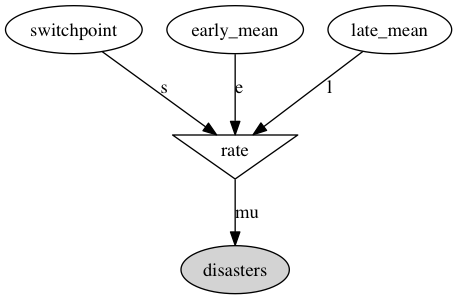

In [27]:
graph = pm.graph.graph(model)
Image(graph.create_png())

In [53]:
print len(disasters.value)
print disasters.value

111
[4 5 4 0 1 4 3 4 0 6 3 3 4 0 2 6 3 3 5 4 5 3 1 4 4 1 5 5 3 4 2 5 2 2 3 4 2
 1 3 2 2 1 1 1 1 3 0 0 1 0 1 1 0 0 3 1 0 3 2 2 0 1 1 1 0 1 0 1 0 0 0 2 1 0
 0 0 1 1 0 2 3 3 1 1 2 1 1 1 1 2 4 2 0 0 1 4 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1]


"To compute its value, rate calls the function we used to create it, passing in the values of its parents."

In [54]:
print len(rate.value)
print rate.value

111
[ 2.94934962  2.94934962  2.94934962  2.94934962  2.94934962  2.94934962
  2.94934962  2.94934962  2.94934962  2.94934962  2.94934962  2.94934962
  2.94934962  2.94934962  2.94934962  2.94934962  2.94934962  2.94934962
  2.94934962  2.94934962  2.94934962  2.94934962  2.94934962  2.94934962
  2.94934962  2.94934962  2.94934962  2.94934962  2.94934962  2.94934962
  2.94934962  2.94934962  2.94934962  2.94934962  2.94934962  2.94934962
  2.94934962  2.94934962  0.9908542   0.9908542   0.9908542   0.9908542
  0.9908542   0.9908542   0.9908542   0.9908542   0.9908542   0.9908542
  0.9908542   0.9908542   0.9908542   0.9908542   0.9908542   0.9908542
  0.9908542   0.9908542   0.9908542   0.9908542   0.9908542   0.9908542
  0.9908542   0.9908542   0.9908542   0.9908542   0.9908542   0.9908542
  0.9908542   0.9908542   0.9908542   0.9908542   0.9908542   0.9908542
  0.9908542   0.9908542   0.9908542   0.9908542   0.9908542   0.9908542
  0.9908542   0.9908542   0.9908542   0.9908542   0.99

In [31]:
early_mean.value

array(0.8552939373903714)

In [32]:
late_mean.value

array(1.6488960503426273)

In [33]:
switchpoint.value

array(82)

We can evaluate the probability mass or density at a variable's current value, given the value of the parents of the variable, using logp. Logp returns the logarithm of a variable's mass/density.

In [34]:
switchpoint.logp

-4.709530201312334

In [35]:
disasters.logp

-246.20570390704785

In [36]:
early_mean.logp

-0.8552939373903714

In [37]:
late_mean.logp

-1.6488960503426273

In [40]:
mcmc = pm.MCMC(model)
mcmc.sample(iter=10000, burn=1000, thin=10)

 [-----------------100%-----------------] 10000 of 10000 complete in 1.5 sec

We've just fit the model - what does that mean? 
"Fitting a model means characterizing its posterior distribution somehow. In this case, we are trying to represent the posterior p(s,e,l|D) by a set of joint samples from it. To produce these samples, the MCMC sampler randomly updates the values of switchpoint, early_mean and late_mean according to the Metropolis-Hastings algorithm [Gelman2004] over a specified number of iterations (iter).

As the number of samples grows sufficiently large, the MCMC distributions of switchpoint, early_mean and late_mean converge to their joint stationary distribution. In other words, their values can be considered as random draws from the posterior p(s,e,l|D)."

In [45]:
mcmc.trace('switchpoint')[:]

array([37, 42, 40, 36, 39, 39, 42, 37, 38, 42, 40, 38, 38, 46, 35, 40, 37,
       37, 37, 39, 42, 42, 41, 41, 41, 39, 39, 41, 43, 37, 42, 42, 43, 36,
       39, 39, 39, 39, 39, 41, 39, 39, 41, 36, 40, 40, 41, 41, 39, 46, 40,
       37, 41, 41, 41, 37, 37, 39, 39, 36, 40, 39, 40, 40, 41, 41, 41, 41,
       41, 41, 41, 37, 38, 41, 41, 41, 39, 40, 40, 43, 39, 41, 41, 41, 41,
       41, 41, 43, 41, 41, 41, 41, 41, 41, 41, 41, 40, 40, 40, 42, 42, 36,
       43, 43, 43, 43, 43, 37, 37, 40, 40, 40, 40, 40, 39, 39, 43, 43, 43,
       42, 42, 42, 36, 36, 36, 36, 44, 44, 44, 44, 44, 44, 43, 43, 43, 43,
       43, 43, 43, 43, 43, 43, 43, 43, 39, 40, 40, 40, 40, 39, 39, 39, 39,
       39, 39, 38, 38, 38, 38, 43, 36, 40, 38, 37, 37, 39, 39, 39, 39, 39,
       39, 39, 39, 39, 39, 39, 39, 39, 39, 41, 41, 33, 37, 46, 46, 46, 46,
       46, 46, 46, 46, 35, 40, 39, 39, 40, 40, 40, 36, 39, 39, 39, 42, 36,
       36, 36, 43, 43, 43, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
       39, 39, 39, 39, 39

(array([   8.,   70.,  154.,  259.,  209.,  114.,   74.,   10.,    0.,    2.]),
 array([ 0.61581398,  0.6980407 ,  0.78026742,  0.86249414,  0.94472086,
         1.02694759,  1.10917431,  1.19140103,  1.27362775,  1.35585448,
         1.4380812 ]),
 <a list of 10 Patch objects>)

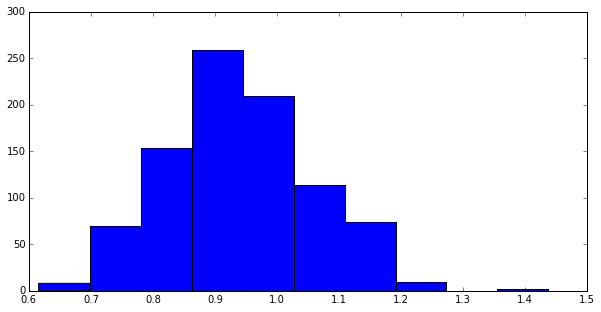

In [47]:
hist(mcmc.trace('late_mean')[:])

(array([  10.,   49.,  133.,  249.,  247.,  135.,   56.,   16.,    4.,    1.]),
 array([ 2.23822013,  2.44267359,  2.64712705,  2.85158051,  3.05603397,
         3.26048744,  3.4649409 ,  3.66939436,  3.87384782,  4.07830128,
         4.28275474]),
 <a list of 10 Patch objects>)

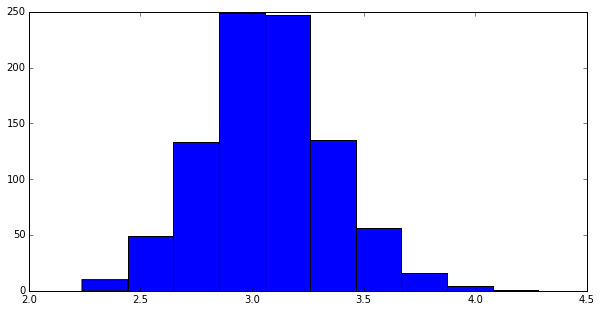

In [48]:
hist(mcmc.trace('early_mean')[:])

(array([   3.,    9.,  131.,   43.,  151.,  381.,   85.,   62.,    6.,   29.]),
 array([ 33. ,  34.4,  35.8,  37.2,  38.6,  40. ,  41.4,  42.8,  44.2,
         45.6,  47. ]),
 <a list of 10 Patch objects>)

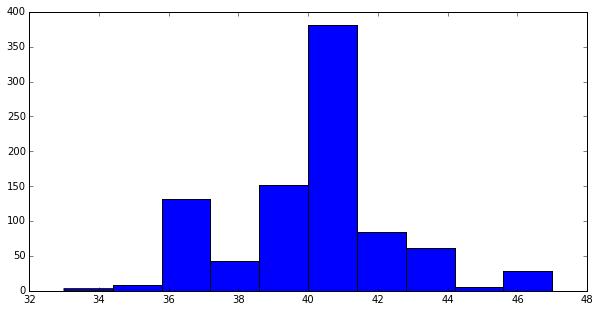

In [49]:
hist(mcmc.trace('switchpoint')[:])

Plotting early_mean
Plotting late_mean
Plotting switchpoint


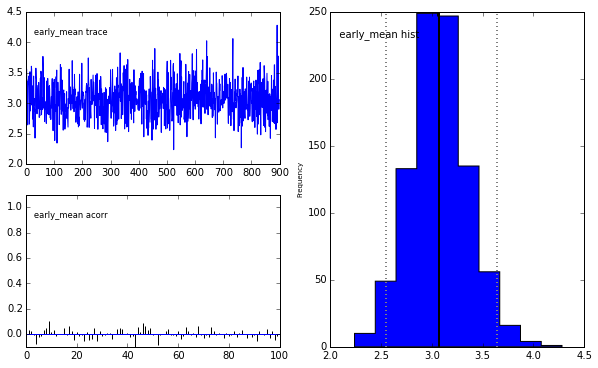

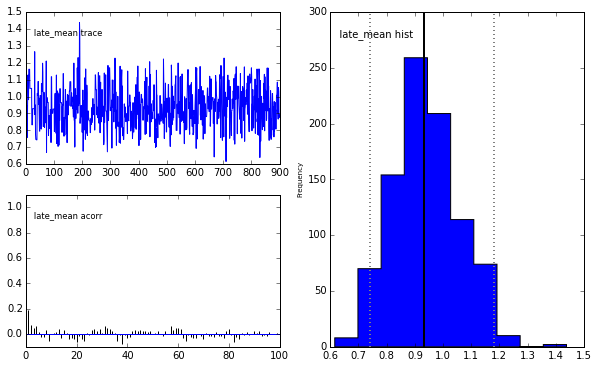

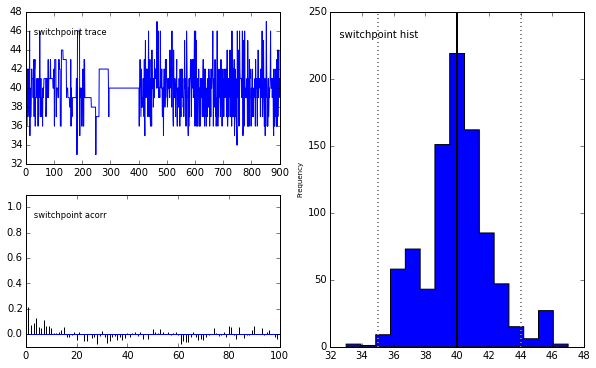

In [51]:
pm.Matplot.plot(mcmc)

In [52]:
mcmc.stats()

{'early_mean': {'95% HPD interval': array([ 2.55064898,  3.64059535]),
  'mc error': 0.0094206970931275096,
  'mean': 3.0699342730540744,
  'n': 900,
  'quantiles': {2.5: 2.5507917561885756,
   25: 2.8853763296132637,
   50: 3.0664830963503147,
   75: 3.2451145796292309,
   97.5: 3.6529748914545777},
  'standard deviation': 0.28538177135787113},
 'late_mean': {'95% HPD interval': array([ 0.74101374,  1.18062658]),
  'mc error': 0.0045514346450492259,
  'mean': 0.93900369403531492,
  'n': 900,
  'quantiles': {2.5: 0.72758135735213481,
   25: 0.85996925732508456,
   50: 0.93262179881283891,
   75: 1.0125619942353159,
   97.5: 1.170016381048359},
  'standard deviation': 0.117587713100157},
 'rate': {'95% HPD interval': array([[ 2.55064898,  2.55064898,  2.55064898,  2.55064898,  2.55064898,
           2.55064898,  2.55064898,  2.55064898,  2.55064898,  2.55064898,
           2.55064898,  2.55064898,  2.55064898,  2.55064898,  2.55064898,
           2.55064898,  2.55064898,  2.55064898,  2